## Install and import libraries

In [ ]:
!pip install emoji && yes | pip install -U pip setuptools wheel emoji

In [ ]:
import numpy as np
import pandas as pd
import spacy
import emoji
import pickle
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout, LSTM, Activation, Bidirectional, Embedding, GlobalMaxPool1D
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping

## Download and import the data

In [ ]:
! pip install -q kaggle
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d jarupula/yahoo-answers-dataset

 95% 295M/309M [00:02<00:00, 102MB/s]
100% 309M/309M [00:02<00:00, 115MB/s]


In [ ]:
! unzip yahoo-answers-dataset.zip -d data

Archive:  yahoo-answers-dataset.zip
  inflating: data/classes.txt        
  inflating: data/readme.txt         
  inflating: data/test.csv           
  inflating: data/train.csv          


In [ ]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 136.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [ ]:
df_classes = pd.read_csv('/content/data/classes.txt',header=None,names=['classes'])
df_classes.index = np.arange(1, len(df_classes)+1)

In [ ]:
df = pd.read_csv('/content/data/train.csv',sep=',' ,header=None,names=['label','question_title','question_content','best_answer'])

In [ ]:
df1 = df.drop(df.index[100000:])
df1.head()

,label,question_title,question_content,best_answer
0,5,why doesn't an optical mouse work on a glass t...,or even on some surfaces?,Optical mice use an LED and a camera to rapidl...
1,6,What is the best off-road motorcycle trail ?,long-distance trail throughout CA,i hear that the mojave road is amazing!<br />\...
2,3,What is Trans Fat? How to reduce that?,I heard that tras fat is bad for the body. Wh...,Trans fats occur in manufactured foods during ...
3,7,How many planes Fedex has?,I heard that it is the largest airline in the ...,according to the www.fedex.com web site:\nAir ...
4,7,"In the san francisco bay area, does it make se...",the prices of rent and the price of buying doe...,renting vs buying depends on your goals. <br /...


In [ ]:
df1.shape

(100000, 4)

In [ ]:
df1.dropna(subset = ["best_answer"], inplace=True)
df1.dropna(subset = ["question_title"], inplace=True)

In [ ]:
df1.shape

(99983, 4)

In [ ]:
df1 = df1.reset_index()
df1 = df1.drop(['index', 'question_content'], axis = 1)

In [ ]:
df1.head()

,label,question_title,best_answer
0,5,why doesn't an optical mouse work on a glass t...,Optical mice use an LED and a camera to rapidl...
1,6,What is the best off-road motorcycle trail ?,i hear that the mojave road is amazing!<br />\...
2,3,What is Trans Fat? How to reduce that?,Trans fats occur in manufactured foods during ...
3,7,How many planes Fedex has?,according to the www.fedex.com web site:\nAir ...
4,7,"In the san francisco bay area, does it make se...",renting vs buying depends on your goals. <br /...


In [ ]:
set(df['label'])

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10}

In [ ]:
Classes = df_classes['classes']
Classes

1          Society & Culture
2      Science & Mathematics
3                     Health
4      Education & Reference
5       Computers & Internet
6                     Sports
7         Business & Finance
8      Entertainment & Music
9     Family & Relationships
10     Politics & Government
Name: classes, dtype: object

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


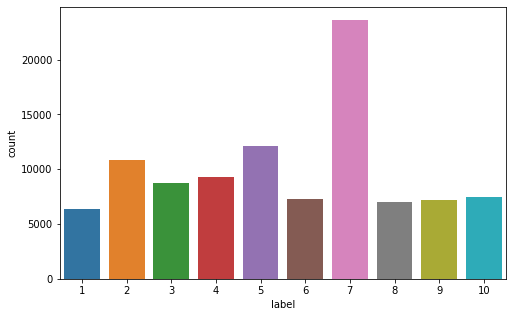

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
sns.countplot(df1['label'])
plt.show()

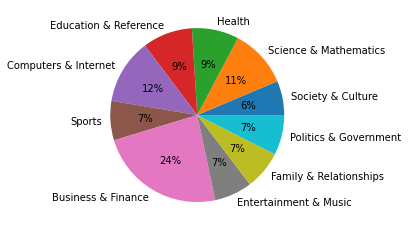

In [ ]:
d = []
for i in range(1,11):
  d.append(len(df1[df1['label']==i]))

plt.pie(d, labels = df_classes['classes'], autopct='%.0f%%')
plt.show()

## Cleaning data

In [ ]:
nlp = spacy.load("en_core_web_sm")

In [ ]:
def clean_data(questions):
  cleaned_data = []
  i=0
  for question  in questions:
      doc = nlp(question)
      lst = [str(token.lemma_).lower() for token in doc if not (token.is_stop or token in emoji.UNICODE_EMOJI or token.is_punct)]
      cleaned_data.append(lst)
      i += 1
      if i%10000==0:
        print(f"{i} sentences were cleaned")
  print(f"{i} sentences were cleaned")   
  return cleaned_data
#----------------------------------------#
cleaned_data = clean_data(df1['question_title'])

In [ ]:
b_file = open("cleaned_data.pkl", "wb")
pickle.dump(cleaned_data, b_file)
b_file.close()

In [ ]:
b_file = open("cleaned_data.pkl", "rb")
cleaned_data = pickle.load(b_file)

In [ ]:
# dic = {
#     classs1: [(q1,ans1),(q2,ans2),....]
#     classs2: [(q1,ans1),(q2,ans2),....]
#     classs3: [(q1,ans1),(q2,ans2),....]
#     classs4: [(q1,ans1),(q2,ans2),....]
#     .
#     .
#     .
#     classs10: [(q1,ans1),(q2,ans2),....]
#   }

def build_dic(df,cleaned_data):
  dic = { 1:[], 2:[], 3:[], 4:[], 5:[], 6:[], 7:[], 8:[], 9:[], 10:[] }
  for i in range(df.shape[0]):
    raw = df.loc[i]
    dic[raw.label].append((cleaned_data[i], raw.best_answer))
  return dic

dic = build_dic(df1,cleaned_data)

In [ ]:
a_file = open("dic.pkl", "wb")
pickle.dump(dic, a_file)
a_file.close()

In [ ]:
a_file = open("dic.pkl", "rb")
dic = pickle.load(a_file)

## Encoding the data

In [ ]:
def clean_preprocessing(cleaned_data, labels):

    classes = np.unique(labels)

    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(cleaned_data)
    # word to index
    word_index = tokenizer.word_index
    # word_index is a dictionary contains indeces for the words like {'for': 8, 'is': 9, 'me': 10, ...}
    ls=[]
    for c in cleaned_data:
        ls.append(len(c))
    maxLen=int(np.percentile(ls, 98))
    print(f"The maxLen is {maxLen}")
    # train_sequences is vectors where each vector represents a sentence
    data_sequences = tokenizer.texts_to_sequences(cleaned_data)
    data_sequences = pad_sequences(data_sequences, maxlen=maxLen, padding='post')

    # Convert our labels into one-hot encoded
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(classes)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)

    onehot_encoder = OneHotEncoder(sparse=False)
    onehot_encoder.fit(integer_encoded)

    data_label_encoded = label_encoder.transform(labels)
    data_label_encoded = data_label_encoded.reshape(len(data_label_encoded), 1)
    data_label = onehot_encoder.transform(data_label_encoded)


    with open('tokenizer.pkl','wb') as file:
        pickle.dump(tokenizer,file)

    with open('label_encoder.pkl','wb') as file:
        pickle.dump(label_encoder,file)

    return data_sequences, data_label, word_index, maxLen
#------------------------------------------------------------------#
data_sequences, data_label, word_index, maxLen = clean_preprocessing(cleaned_data, df1['label'])

In [ ]:
train_data, val_test_data, train_labels, val_test_labels = train_test_split(data_sequences, data_label,test_size = 0.3,stratify=data_label)
test_data, val_data, test_labels, val_labels = train_test_split(val_test_data, val_test_labels,test_size = 0.2)
print(train_data[0])
print(train_labels[0])

[8438  202 2523    0    0    0    0    0    0    0    0]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [ ]:
# !pip install wget
# import wget
# url ='https://www.dropbox.com/s/a247ju2qsczh0be/glove.6B.100d.txt?dl=1'
# wget.download(url)

def GloVe(data = 'glove.6B.100d.txt'):

  embeddings_index={}
  with open(data, encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
  return embeddings_index
#--------------------------------------------------------------------------------------------#
def embeddingWights(word_index, max_num_words=50000):
  embeddings_index = GloVe()
  all_embs = np.stack(embeddings_index.values())
  emb_mean,emb_std = all_embs.mean(), all_embs.std()

  num_words = min(max_num_words, len(word_index))+1

  embedding_dim=len(embeddings_index['the'])

  embedding_wights = np.random.normal(emb_mean, emb_std, (num_words, embedding_dim))

  for word, i in word_index.items():
      if i >= max_num_words:
          break
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          embedding_wights[i] = embedding_vector
  
  return embedding_wights, num_words

#--------------------------------------------------------------------------------------------#
embedding_wights, num_words = embeddingWights(word_index)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
def defineModel(num_words, maxLen, embedding_wights, numberOFclasses):

  model = Sequential()
  model.add(Embedding(input_dim=num_words, output_dim=100, trainable=False,input_length=maxLen, weights=[embedding_wights]))
  model.add(Bidirectional(LSTM(256, return_sequences=True, recurrent_dropout=0.1, dropout=0.1), 'concat'))
  model.add(Dropout(0.2))
  model.add(LSTM(128, return_sequences=False, recurrent_dropout=0.1, dropout=0.1))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='sigmoid'))
  model.add(Dropout(0.2))
  model.add(Dense(numberOFclasses, activation='softmax'))
  model.compile(loss = 'categorical_crossentropy', optimizer = "adam", metrics = ["accuracy"])

  return model


In [ ]:
model = defineModel(num_words, maxLen, embedding_wights, numberOFclasses=10)
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 11, 100)           4758100   
                                                                 
 bidirectional_5 (Bidirectio  (None, 11, 256)          234496    
 nal)                                                            
                                                                 
 global_max_pooling1d_5 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_12 (Dense)            (None, 200)               51400     
                                                                 
 dropout_8 (Dropout)         (None, 200)               0         
                                                                 
 dense_13 (Dense)            (None, 100)              

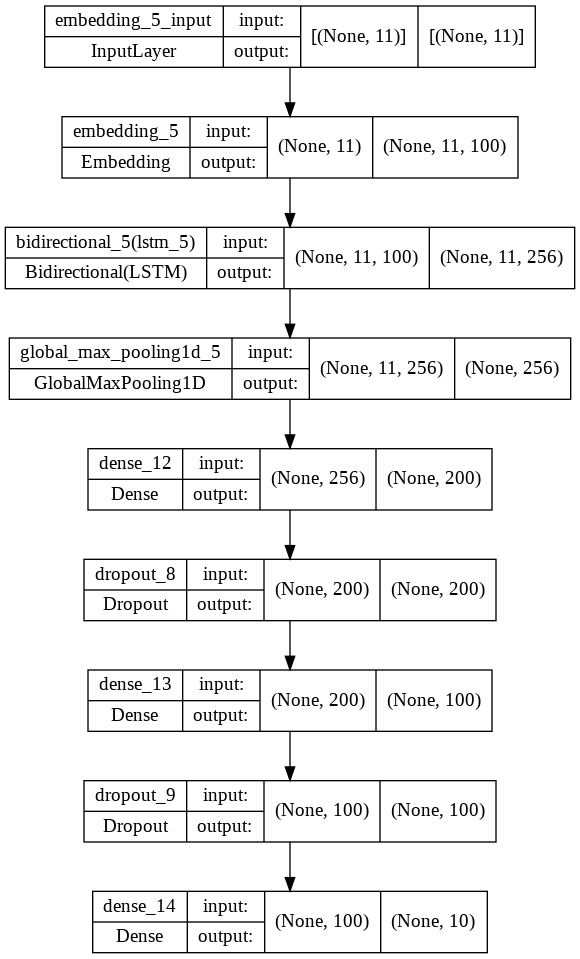

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
callback = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=6, verbose=1)
history = model.fit(train_data, train_labels, epochs = 50,
          batch_size = 256, shuffle=True,
          validation_data=[val_data, val_labels],
          callbacks=[callback])

model.save('intents.h5')

Epoch 1/50
274/274 [==============================] - 42s 136ms/step - loss: 1.5280 - accuracy: 0.4793 - val_loss: 1.2368 - val_accuracy: 0.5849
Epoch 2/50
274/274 [==============================] - 36s 132ms/step - loss: 1.2803 - accuracy: 0.5706 - val_loss: 1.1875 - val_accuracy: 0.5993
Epoch 3/50
274/274 [==============================] - 40s 147ms/step - loss: 1.2231 - accuracy: 0.5889 - val_loss: 1.1624 - val_accuracy: 0.6136
Epoch 4/50
274/274 [==============================] - 39s 141ms/step - loss: 1.1855 - accuracy: 0.6020 - val_loss: 1.1464 - val_accuracy: 0.6161
Epoch 5/50
274/274 [==============================] - 35s 127ms/step - loss: 1.1535 - accuracy: 0.6142 - val_loss: 1.1322 - val_accuracy: 0.6178
Epoch 6/50
274/274 [==============================] - 35s 128ms/step - loss: 1.1254 - accuracy: 0.6213 - val_loss: 1.1272 - val_accuracy: 0.6204
Epoch 7/50
274/274 [==============================] - 35s 128ms/step - loss: 1.0984 - accuracy: 0.6298 - val_loss: 1.1223 - val_ac

In [ ]:
results = model.evaluate(test_data, test_labels)
print("test loss, test acc:", results)

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

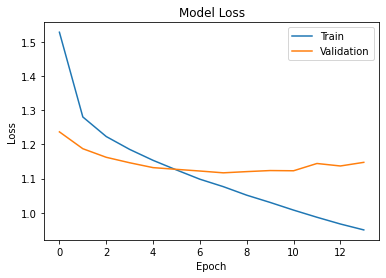

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
def useModel():

  model = load_model('intents.h5')

  with open('tokenizer.pkl','rb') as file:
    tokenizer = pickle.load(file)

  with open('label_encoder.pkl','rb') as file:
    label_encoder = pickle.load(file)
  
  with open('dic.pkl','rb') as file:
    dic = pickle.load(file)
  
  question = input('Enter a question: ')
  while question!='q':
    doc = nlp(question)
    lst = []
    lst = [str(token.lemma_).lower() for token in doc if not (token.is_stop or token in emoji.UNICODE_EMOJI or token.is_punct)]
      
    test_keras = tokenizer.texts_to_sequences(lst)
    test_keras_sequence = pad_sequences(test_keras, maxlen=maxLen, padding='post')
    pred = model.predict(test_keras_sequence)

    L = label_encoder.inverse_transform(np.argmax(pred,1))[0]
    print(f"Your question is in {Classes[L]} field")

    A = test_keras_sequence.reshape(1,-1)
    A = test_keras_sequence.reshape(1,-1)
    lst = []
    for tup in dic[L]:
      B = tup[0]
      B = tokenizer.texts_to_sequences(B)
      B = pad_sequences(B, maxlen=maxLen, padding='post')
      B = B.reshape(1,-1)
      s = cosine_similarity(A,B)
      lst.append(s)
    max_index = np.argmax(lst)
    answer = dic[L][max_index][1]

    print(f"our answer: {answer}")
    text = input('Enter a question: ')

In [ ]:
useModel()